In [28]:
import os
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from glob import glob
from PIL import Image
import torch
import torch.nn as nn
from torch.utils.data import random_split, Dataset, DataLoader
import torchvision
from torchvision import transforms as T
import timm

In [29]:
class CustomDataset(Dataset):
    """
    Custom dataset for loading images from a directory structure where each subdirectory represents a class.
    The class directories should contain image files with a 'jpg' extension.

    Args:
        root (str): Root directory path containing class subdirectories with image files.
        transform (callable, optional): A function/transform that takes in an image and returns a transformed version.
                                        Default is None, meaning no transformation is applied.

    Attributes:
        transform (callable): The transform to be applied on images.
        im_paths (list): List of image file paths in the dataset.
        cls_names (dict): Dictionary mapping class names to integer labels.
        cls_counts (dict): Dictionary holding the count of images for each class.
    """
    def __init__(self, root, transform=None):

        self.transform = transform
        self.im_paths = [im_path for im_path in sorted(glob(f"{root}/*/*jpg"))]
        self.cls_names, self.cls_counts, count, data_count = {}, {}, 0, 0
        
        for idx, im_path in enumerate(self.im_paths):
            class_name = self.get_class(im_path)
            if class_name not in self.cls_names:
                self.cls_names[class_name] = count
                self.cls_counts[class_name] = 1
                count += 1
            else:
                self.cls_counts[class_name] += 1

    def get_class(self, path):
        return os.path.dirname(path).split("/")[-1]

    def __len__(self):
        return len(self.im_paths)

    def __getitem__(self, idx):

        im_path = self.im_paths[idx]
        im = Image.open(im_path).convert("RGB")
        gt = self.cls_names[self.get_class(im_path)]

        if self.transform is not None:
            im = self.transform(im)

        return im, gt



def get_dls(root: str, batch_size: int, transform=None, split=[0.9, 0.05, 0.05], num_workers=0):
    """
    Creates DataLoaders for training, validation, and testing from a dataset located at the 
    specified root directory.The dataset is expected to be organized such that each class is in a 
    separate subdirectory.

    Returns:
        tuple: Contains three DataLoader objects for the training, validation, and testing splits 
            of the dataset, and a dictionary mapping class names to class indices.
    """

    dataset = CustomDataset(root=root, transform=transform)

    total_len = len(dataset)
    train_len = int(total_len * split[0])
    val_len = int(total_len * split[1])
    test_len = total_len - (train_len + val_len)

    train_dataset, val_dataset, test_dataset = random_split(dataset=dataset, lengths=[train_len, val_len, test_len])

    train_loader, val_loader, test_loader = (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers),
        DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=num_workers),
    )

    return train_loader, val_loader, test_loader, dataset.cls_names


In [30]:
# Hyper Parameters
ROOT = "data"
BATCH_SIZE = 64
mean, std, im_size = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225], 224
TRANSFORM = T.Compose(
    [T.Resize((im_size, im_size)), T.ToTensor(), T.Normalize(mean=mean, std=std)]
)

train_loader, val_loader, test_loader, classes = get_dls(root=ROOT, batch_size=BATCH_SIZE, transform=TRANSFORM)

print(f"len train_loader: {len(train_loader)}, Items: {len(train_loader) * BATCH_SIZE}")
print(f"len val_loader: {len(val_loader)}, Items: {len(val_loader) * BATCH_SIZE}")
print(classes)

len train_loader: 44, Items: 2816
len val_loader: 3, Items: 192
{'airplane': 0, 'ambulance': 1, 'bicycle': 2, 'boat': 3, 'bus': 4, 'car': 5, 'fire_truck': 6, 'helicopter': 7, 'hovercraft': 8, 'jet_ski': 9, 'kayak': 10, 'motorcycle': 11, 'rickshaw': 12, 'scooter': 13, 'segway': 14, 'skateboard': 15, 'tractor': 16, 'truck': 17, 'unicycle': 18, 'van': 19}


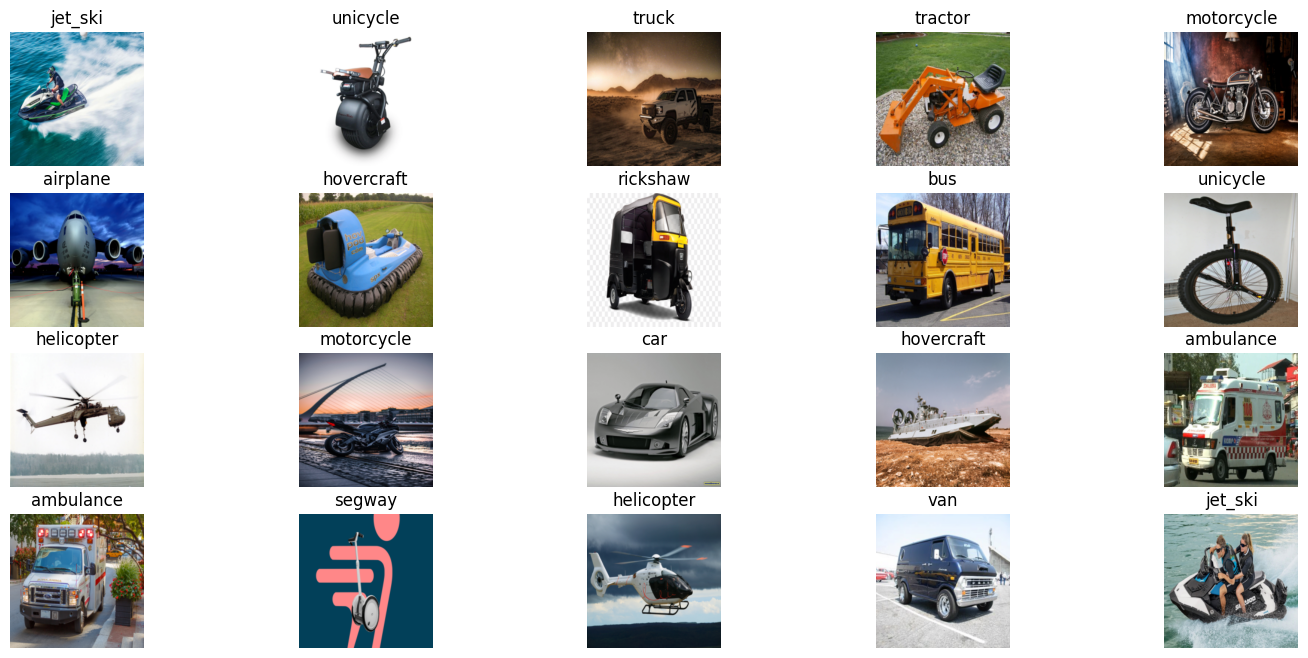

In [31]:
def tensor_2_im(t, t_type="rgb"):
    """
    Converts a tensor image to a numpy image, optionally converting from 
    grayscale or RGB format.
    """

    gray_transforms = T.Compose(
        [T.Normalize(mean=[0.0], std=[1 / 0.5]), T.Normalize(mean=[-0.5], std=[1])]
    )
    rgb_transforms = T.Compose(
        [
            T.Normalize(mean=[0.0, 0.0, 0.0], std=[1 / 0.229, 1 / 0.224, 1 / 0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1.0, 1.0, 1.0]),
        ]
    )

    invTransform = gray_transforms if t_type == "gray" else rgb_transforms

    return (
        (invTransform(t) * 255)
        .detach()
        .squeeze()
        .cpu()
        .permute(1, 2, 0)
        .numpy()
        .astype(np.uint8)
        if t_type == "gray"
        else (invTransform(t) * 255)
        .detach()
        .cpu()
        .permute(1, 2, 0)
        .numpy()
        .astype(np.uint8)
    )


def visualize(data, n_ims, rows, cmap=None, cls_names=None):
    """
    Visualizes a subset of images from the dataset with their ground truth labels.
    """
    
    assert cmap in [
        "rgb",
        "gray",
    ], "Rasmni oq-qora yoki rangli ekanini aniqlashtirib bering!"
    if cmap == "rgb":
        cmap = "viridis"

    plt.figure(figsize=(18, 8))
    indexlar = [random.randint(0, len(data) - 1) for _ in range(n_ims)]
    for idx, index in enumerate(indexlar):

        im, gt = data[index]
        # Start plot
        plt.subplot(rows, n_ims // rows, idx + 1)
        if cmap:
            plt.imshow(tensor_2_im(im, cmap), cmap=cmap)
        else:
            plt.imshow(tensor_2_im(im))
        plt.axis("off")
        if cls_names is not None:
            plt.title(f"{cls_names[int(gt)]}")
        else:
            plt.title(f"{gt}")


visualize(train_loader.dataset, 20, 4, "rgb", list(classes.keys()))

/var/folders/9b/k35zb79j27vcvxd_45b3jpd80000gn/T/ipykernel_1851/875978153.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(cls_names, rotation=60)


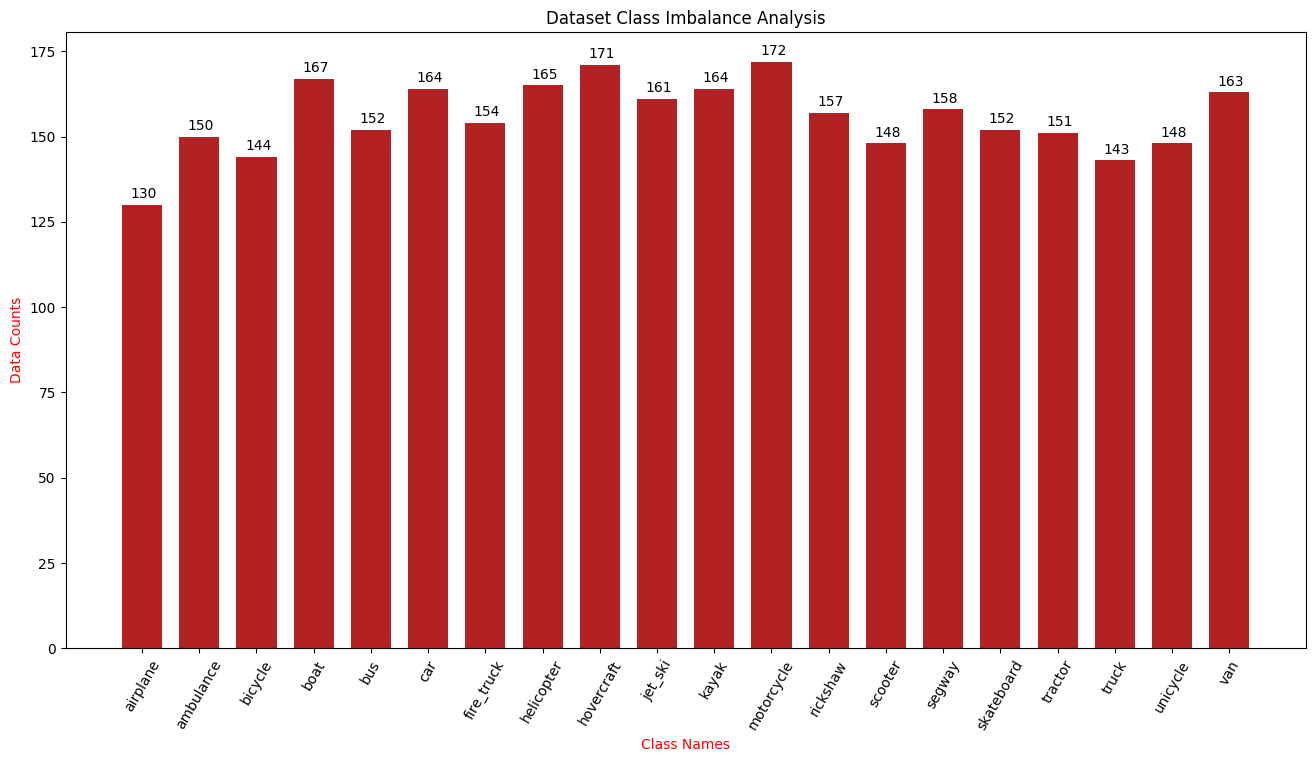

In [32]:
def data_analysis(root, transform):
    """
    Visualizes the class distribution within a dataset by plotting the number
    of instances for each class. This can help identify class imbalances.
    """
    dataset = CustomDataset(root=root, transform=transform)
    cls_counts, width, text_width = dataset.cls_counts, 0.7, 0.2
    text_height = 2
    cls_names = list(cls_counts.keys())
    counts = list(cls_counts.values())

    fig, ax = plt.subplots(figsize=(16, 8))
    indices = np.arange(len(counts))

    ax.bar(indices, counts, width, color="firebrick")
    ax.set_xlabel("Class Names", color="red")
    ax.set_xticklabels(cls_names, rotation=60)
    ax.set(xticks=indices, xticklabels=cls_names)
    ax.set_ylabel("Data Counts", color="red")
    ax.set_title(f"Dataset Class Imbalance Analysis")

    for i, v in enumerate(counts):
        ax.text(i - text_width, v + text_height, str(v), color="black")


data_analysis(root=ROOT, transform=TRANSFORM)

# `Model`

In [33]:
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)


if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"Using device: {device}")
    print(torch.cuda.get_device_name(0))

elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print(f"Using device: {device}")
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

PyTorch version: 2.2.1
Torchvision version: 0.17.1
Using device: mps
Running on the GPU


In [34]:
def get_metrics(
    model,
    inputs,
    labels,
    criterion,
    epoch_loss,
    epoch_acc
):
    preds = model(inputs)
    loss = criterion(preds, labels)
    return (
        loss,
        epoch_loss + (loss.item()),
        epoch_acc + (torch.argmax(preds, dim=1) == labels).sum().item(),
    )

def train_weights(
    data_loaders,
    data_sizes,
    model,
    optimizer,
    criterion,
    epochs=10,
    training=True,
):
    
    since = time.time()
    train_loader , val_loader = data_loaders['train'], data_loaders['val']
      
    best_acc, best_loss, threshold, not_improved, patience = 0.0, float(torch.inf), 0.01, 0, 5
    train_losses, val_losses, train_accs, val_accs = [], [], [], []
    save_prefix, save_dir = "vehicles", "saved_models"
    print("Start training...")
    
    for epoch in range(epochs):

        epoch_loss, epoch_acc = 0.0, 0.0
        n_total_steps = len(data_loaders['train'])
        
        for i, (inputs, labels) in enumerate(train_loader):

            inputs, labels = inputs.to(device), labels.to(device)

            loss, epoch_loss, epoch_acc = get_metrics(
                model, inputs, labels, criterion, epoch_loss, epoch_acc
            )
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_to_track = epoch_loss / len(train_loader)
        train_acc_to_track = epoch_acc / len(train_loader.dataset)
        train_losses.append(train_loss_to_track)
        train_accs.append(train_acc_to_track)
        
        print(
            f"Epoch [{epoch+1}/{epochs}], Step [{i+1}/{n_total_steps}], Loss: {train_loss_to_track:.3f}, Acc: {train_acc_to_track:.3f}"
        )

        # print(f"{epoch + 1}-epoch train process is completed!")
        # print(f"{epoch + 1}-epoch train loss          -> {train_loss_to_track:.3f}")
        # print(f"{epoch + 1}-epoch train accuracy      -> {train_acc_to_track:.3f}")



        #validation
        model.eval()
        with torch.no_grad():
            val_epoch_loss, val_epoch_acc = 0, 0
            n_total_steps = len(data_loaders['val'])
            
            for idx, (inputs, labels) in enumerate(val_loader):
                inputs, labels = inputs.to(device) , labels.to(device)

                preds = model(inputs)
                loss = criterion(preds, labels)
                pred_cls = torch.argmax(preds.data, dim=1)
                val_epoch_acc += (pred_cls == labels).sum().item()
                val_epoch_loss += loss.item()

            val_loss_to_track = val_epoch_loss / len(val_loader)
            val_acc_to_track = val_epoch_acc / len(val_loader.dataset)
            val_losses.append(val_loss_to_track)
            val_accs.append(val_acc_to_track)

            # print(f"{epoch + 1}-epoch validation process is completed!")
            # print(f"{epoch + 1}-epoch validation loss     -> {val_loss_to_track:.3f}")
            # print(f"{epoch + 1}-epoch validation accuracy -> {val_acc_to_track:.3f}")
            
            print(
            f"Epoch [{epoch+1}/{epochs}], Step [{idx+1}/{n_total_steps}], Loss: {val_loss_to_track:.3f}, Acc: {val_acc_to_track:.3f}"
            )

            if val_loss_to_track < (best_loss + threshold):
                os.makedirs(save_dir, exist_ok=True)
                best_loss = val_loss_to_track
                torch.save(model.state_dict(), f"{save_dir}/{save_prefix}_best_model.pth")

            else:
                not_improved += 1
                print(f"Loss value did not decrease for {not_improved} epochs")
                if not_improved == patience:
                    print(
                        f"Stop training since loss value did not decrease for {patience} epochs."
                    )
                    break
        
        acc_loss_dict = {
            'train_losses': train_losses, 'train_accs': train_accs,
            'val_losses': val_losses, 'val_accs': val_accs
            }
        
        return acc_loss_dict
        



In [35]:
# Hyperparams
EPOCHS = 3
LR_RATE = 3e-4

model = timm.create_model("rexnet_150", pretrained=True, num_classes=len(classes)).to(device).eval()
optimizer = torch.optim.Adam(params=model.parameters(), lr=LR_RATE)
criterion = nn.CrossEntropyLoss()        
        
data_loaders = {"train": train_loader, "val": val_loader}
        

acc_loss_dict = train_weights(
                data_loaders,
                100,
                model,
                optimizer,
                criterion,
                epochs=EPOCHS,
            )



Start training...


KeyboardInterrupt: 

In [36]:
def learning_curves(tr_losses, val_losses, tr_accs, val_accs):

    plt.figure(figsize=(10, 5))
    plt.plot(tr_losses, label="Train Loss", c="red")
    plt.plot(val_losses, label="Validation Loss", c="blue")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Values")
    plt.xticks(
        ticks=np.arange(len(tr_losses)),
        labels=[i for i in range(1, len(tr_losses) + 1)],
    )
    plt.legend()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(tr_accs, label="Train Accuracy", c="orangered")
    plt.plot(val_accs, label="Validation Accuracy", c="darkgreen")
    plt.xlabel("Epochs")
    plt.ylabel("Loss Accuracy Scores")
    plt.xticks(
        ticks=np.arange(len(tr_accs)), labels=[i for i in range(1, len(tr_accs) + 1)]
    )
    plt.legend()
    plt.show()


learning_curves(
    acc_loss_dict['train_losses'], 
    acc_loss_dict['val_losses'], 
    acc_loss_dict['train_accs'], 
    acc_loss_dict['val_accs']
    )

NameError: name 'acc_loss_dict' is not defined